In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_parquet("../data/stock_data.parquet")

# Flatten multi-index columns
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]
df.index = pd.to_datetime(df.index)

# Forward-fill and drop any remaining NaNs
df = df.ffill().dropna()

# Add date encodings
df['day_of_year'] = df.index.dayofyear
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [3]:
selected_stocks = ['NVDA', 'AAPL', 'KO']
features = ['Open', 'High', 'Low', 'Close', 'Volume']

summary = pd.DataFrame()

for stock in selected_stocks:
    for feat in features:
        col = f"{stock}_{feat}"
        if col in df.columns:
            stats = df[col].describe()
            summary[col] = stats

# Transpose to get rows as features
display(summary.T)


,count,mean,std,min,25%,50%,75%,max
NVDA_Open,1760.0,2.884458e+01,3.562636e+01,3.136509e+00,6.166905e+00,1.456254e+01,2.961152e+01,1.493260e+02
NVDA_High,1760.0,2.937110e+01,3.624621e+01,3.223049e+00,6.229971e+00,1.483754e+01,3.026395e+01,1.528654e+02
NVDA_Low,1760.0,2.826701e+01,3.488019e+01,3.086173e+00,6.072602e+00,1.421594e+01,2.851291e+01,1.462365e+02
NVDA_Close,1760.0,2.884287e+01,3.558522e+01,3.151139e+00,6.154171e+00,1.454935e+01,2.937055e+01,1.488561e+02
NVDA_Volume,1760.0,4.627887e+08,2.109707e+08,9.788400e+07,3.186564e+08,4.277150e+08,5.651082e+08,2.511528e+09
AAPL_Open,1760.0,1.220710e+02,5.918423e+01,3.434220e+01,5.445594e+01,1.322161e+02,1.690040e+02,2.579064e+02
AAPL_High,1760.0,1.234061e+02,5.972898e+01,3.475723e+01,5.496579e+01,1.333045e+02,1.707816e+02,2.598143e+02
AAPL_Low,1760.0,1.208440e+02,5.869370e+01,3.386993e+01,5.388581e+01,1.304979e+02,1.677703e+02,2.573470e+02
AAPL_Close,1760.0,1.221944e+02,5.925894e+01,3.391525e+01,5.426225e+01,1.318662e+02,1.692288e+02,2.587355e+02
AAPL_Volume,1760.0,1.001781e+08,5.521652e+07,2.323470e+07,6.308165e+07,8.674660e+07,1.214590e+08,4.265100e+08


In [4]:
# Compute 14-day rolling volatility stats for each stock
volatility_summary = {}

for stock in selected_stocks:
    close_col = f"{stock}_Close"
    rolling_vol = df[close_col].rolling(window=14).std()

    volatility_summary[stock] = {
        'Mean Volatility': rolling_vol.mean(),
        'Max Volatility': rolling_vol.max(),
        'Volatility StdDev': rolling_vol.std()
    }

vol_df = pd.DataFrame(volatility_summary).T.round(3)
display(vol_df)

print(vol_df.to_latex(index=True, caption="14-Day Rolling Volatility Summary", label="tab:vol_summary"))


,Mean Volatility,Max Volatility,Volatility StdDev
NVDA,1.295,11.177,1.789
AAPL,3.015,9.988,1.843
KO,0.746,5.501,0.499


\begin{table}
\caption{14-Day Rolling Volatility Summary}
\label{tab:vol_summary}
\begin{tabular}{lrrr}
\toprule
 & Mean Volatility & Max Volatility & Volatility StdDev \\
\midrule
NVDA & 1.295000 & 11.177000 & 1.789000 \\
AAPL & 3.015000 & 9.988000 & 1.843000 \\
KO & 0.746000 & 5.501000 & 0.499000 \\
\bottomrule
\end{tabular}
\end{table}



In [5]:
# Define split points
total_len = len(df)
split_train = int(0.8 * total_len)
split_val = int(0.9 * total_len)

# Get split indices
train_idx = df.index[:split_train]
val_idx = df.index[split_train:split_val]
test_idx = df.index[split_val:]

# Build volatility table
vol_stats_by_split = {}

for stock in selected_stocks:
    close_col = f"{stock}_Close"
    vol_series = df[close_col].rolling(window=14).std()

    vol_stats_by_split[stock] = {
        'Train Mean': vol_series.loc[train_idx].mean(),
        'Val Mean': vol_series.loc[val_idx].mean(),
        'Test Mean': vol_series.loc[test_idx].mean()
    }

vol_split_df = pd.DataFrame(vol_stats_by_split).T.round(3)
vol_split_df.index.name = "Stock"
display(vol_split_df)
print(vol_split_df.to_latex(index=True, caption="14-Day Rolling Volatility Split by Train/Val/Test", label="tab:vol_summary"))

,Train Mean,Val Mean,Test Mean
Stock,,,
NVDA,0.619,2.383,5.565
AAPL,2.714,3.732,4.690
KO,0.740,0.659,0.878


\begin{table}
\caption{14-Day Rolling Volatility Split by Train/Val/Test}
\label{tab:vol_summary}
\begin{tabular}{lrrr}
\toprule
 & Train Mean & Val Mean & Test Mean \\
Stock &  &  &  \\
\midrule
NVDA & 0.619000 & 2.383000 & 5.565000 \\
AAPL & 2.714000 & 3.732000 & 4.690000 \\
KO & 0.740000 & 0.659000 & 0.878000 \\
\bottomrule
\end{tabular}
\end{table}



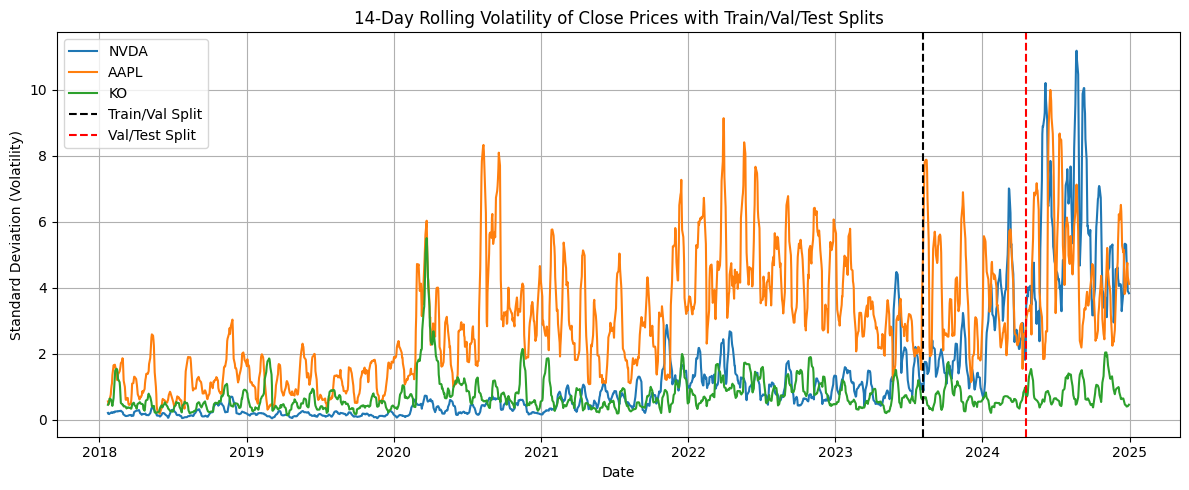

In [7]:
# Define splits
total_len = len(df)
split_train = int(0.8 * total_len)
split_val = int(0.9 * total_len)

# Define window size
window = 14

# Create figure
plt.figure(figsize=(12, 5))

# Plot rolling volatility
for stock in selected_stocks:
    close_col = f"{stock}_Close"
    rolling_vol = df[close_col].rolling(window=window).std()
    plt.plot(df.index, rolling_vol, label=stock)

# Add vertical split lines
plt.axvline(df.index[split_train], color='black', linestyle='--', label='Train/Val Split')
plt.axvline(df.index[split_val], color='red', linestyle='--', label='Val/Test Split')

# Labels and legend
plt.title(f"{window}-Day Rolling Volatility of Close Prices with Train/Val/Test Splits")
plt.xlabel("Date")
plt.ylabel("Standard Deviation (Volatility)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save
plt.show()

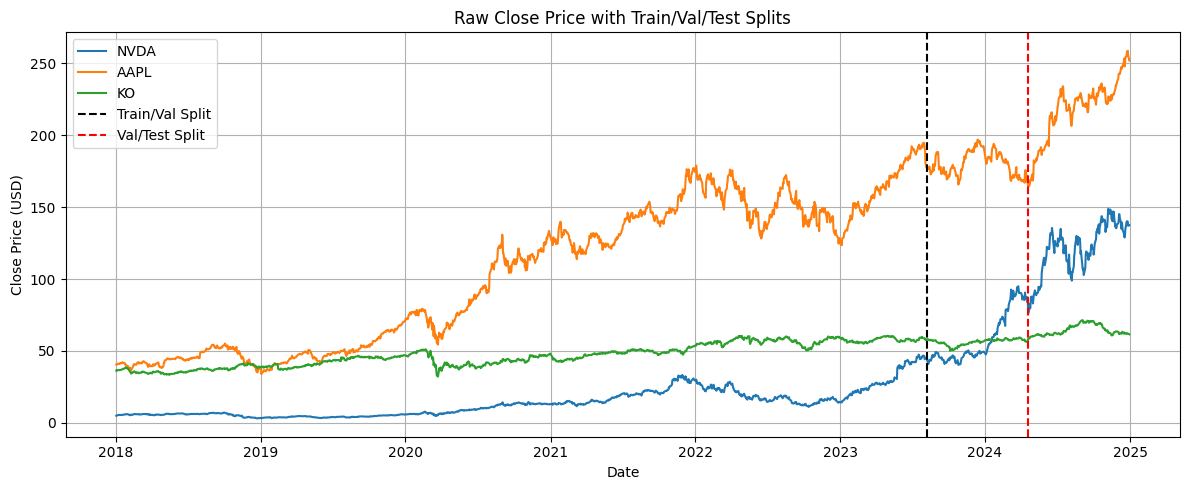

In [12]:
# Define your split points
total_len = len(df)
split_train = int(0.8 * total_len)
split_val = int(0.9 * total_len)

fig, ax = plt.subplots(figsize=(12, 5))

for stock in selected_stocks:
    close_col = f"{stock}_Close"
    ax.plot(df.index, df[close_col], label=stock)

# Draw vertical lines for splits
ax.axvline(df.index[split_train], color='black', linestyle='--', label='Train/Val Split')
ax.axvline(df.index[split_val], color='red', linestyle='--', label='Val/Test Split')

ax.set_title("Raw Close Price with Train/Val/Test Splits")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [13]:
for stock in selected_stocks:
    close_col = f"{stock}_Close"
    print(close_col)
    print(df[close_col].max(), df[close_col].min())

NVDA_Close
148.85606384277344 3.151139259338379
AAPL_Close
258.7355041503906 33.91524887084961
KO_Close
71.4398422241211 32.211666107177734


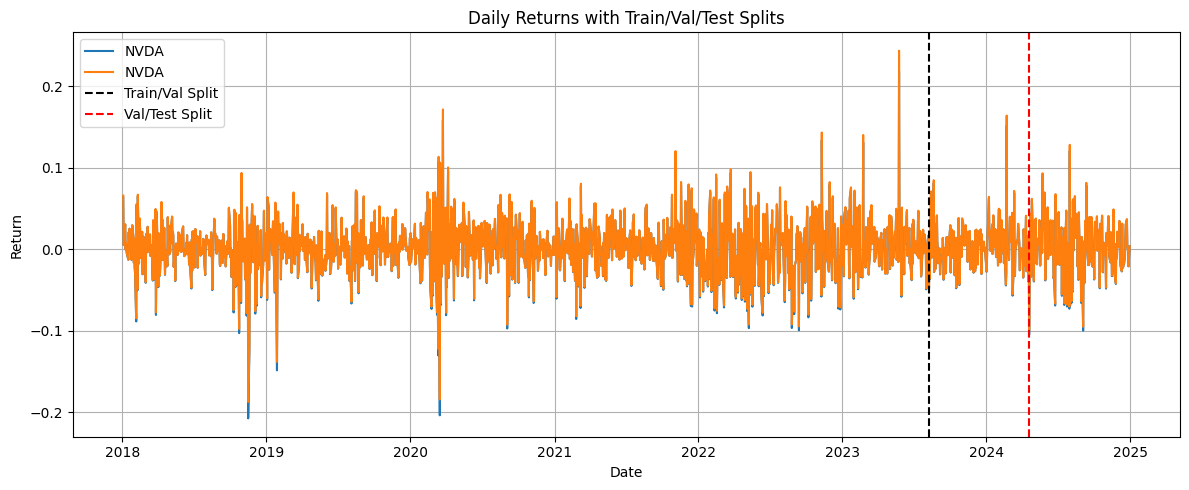

In [24]:
# Compute daily returns
returns_df = pd.DataFrame(index=df.index)

for stock in selected_stocks:
    close_col = f"{stock}_Close"
    if close_col in df.columns:
        returns_df[f"{stock}_Return_Log"] = np.log(df[close_col] / df[close_col].shift(1))
        returns_df[f"{stock}_Return"] = df[close_col].pct_change()

# Drop NaNs from the first row after pct_change
returns_df = returns_df.dropna()

# Plotting daily returns
fig, ax = plt.subplots(figsize=(12, 5))

for stock in selected_stocks:
    if stock != "NVDA":
        continue
    ret_col = f"{stock}_Return_Log"
    ax.plot(returns_df.index, returns_df[ret_col], label=stock)
    ax.plot(returns_df.index, returns_df[f"{stock}_Return"], label=stock)

# Draw vertical lines for splits (same split indices as raw prices)
split_train = int(0.8 * len(returns_df))
split_val = int(0.9 * len(returns_df))

ax.axvline(returns_df.index[split_train], color='black', linestyle='--', label='Train/Val Split')
ax.axvline(returns_df.index[split_val], color='red', linestyle='--', label='Val/Test Split')

ax.set_title("Daily Returns with Train/Val/Test Splits")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd

# Assuming df is already loaded and indexed by datetime
# and has NVDA_* columns like 'NVDA_Open', 'NVDA_High', etc.

# Extract NVDA-related columns
nvda_cols = [col for col in df.columns if col.startswith('NVDA_')]

# Initialize a new DataFrame for log returns
log_returns = pd.DataFrame(index=df.index)

# Compute log returns for each NVDA column
for col in nvda_cols:
    # Avoid division by zero or log of non-positive numbers
    shifted = df[col].shift(1)
    valid = (shifted > 0) & (df[col] > 0)
    log_ret = np.log(df[col] / shifted)
    log_returns[col + '_log_return'] = log_ret.where(valid, np.nan)

# Drop initial NaNs caused by shift
log_returns = log_returns.dropna()

# Print summary
print(log_returns.describe())

# Optionally display full DataFrame
# print(log_returns)


       NVDA_Open_log_return  NVDA_High_log_return  NVDA_Low_log_return  \
count           1759.000000           1759.000000          1759.000000   
mean               0.001891              0.001903             0.001892   
std                0.033160              0.027344             0.029569   
min               -0.188012             -0.184799            -0.190374   
25%               -0.014783             -0.011868            -0.013245   
50%                0.002392              0.001214             0.003468   
75%                0.020683              0.015717             0.017683   
max                0.243082              0.254565             0.206294   

       NVDA_Close_log_return  NVDA_Volume_log_return  
count            1759.000000             1759.000000  
mean                0.001892               -0.000427  
std                 0.032417                0.304131  
min                -0.207711               -1.115979  
25%                -0.015300               -0.187434  
50%

In [36]:
import numpy as np
import pandas as pd

# Assuming df is already loaded and indexed by datetime
nvda_cols = [col for col in df.columns if col.startswith('NVDA_')]

# Define train/test split index (90%)
split_index = int(len(df) * 0.9)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]  # Not needed unless you want to verify scaling stability

# Prepare scaled output DataFrame
minmax_scaled = pd.DataFrame(index=df.index)

# Scale each NVDA column based on training data only
for col in nvda_cols:
    col_min = df_train[col].min()
    col_max = df_train[col].max()
    scaled = (df[col] - col_min) / (col_max - col_min)
    minmax_scaled[col + '_minmax'] = scaled

# Drop NaNs if any
minmax_scaled = minmax_scaled.dropna()

# Show summary stats
print(minmax_scaled.describe())


       NVDA_Open_minmax  NVDA_High_minmax  NVDA_Low_minmax  NVDA_Close_minmax  \
count       1760.000000       1760.000000      1760.000000        1760.000000   
mean           0.277376          0.277742         0.278570           0.279806   
std            0.384389          0.385004         0.385872           0.387556   
min            0.000000          0.000000         0.000000           0.000000   
25%            0.032696          0.031939         0.033038           0.032706   
50%            0.123281          0.123368         0.123126           0.124137   
75%            0.285651          0.287226         0.281291           0.285553   
max            1.577306          1.589489         1.583642           1.586860   

       NVDA_Volume_minmax  
count         1760.000000  
mean             0.151184  
std              0.087408  
min              0.000000  
25%              0.091469  
50%              0.136653  
75%              0.193576  
max              1.000000  


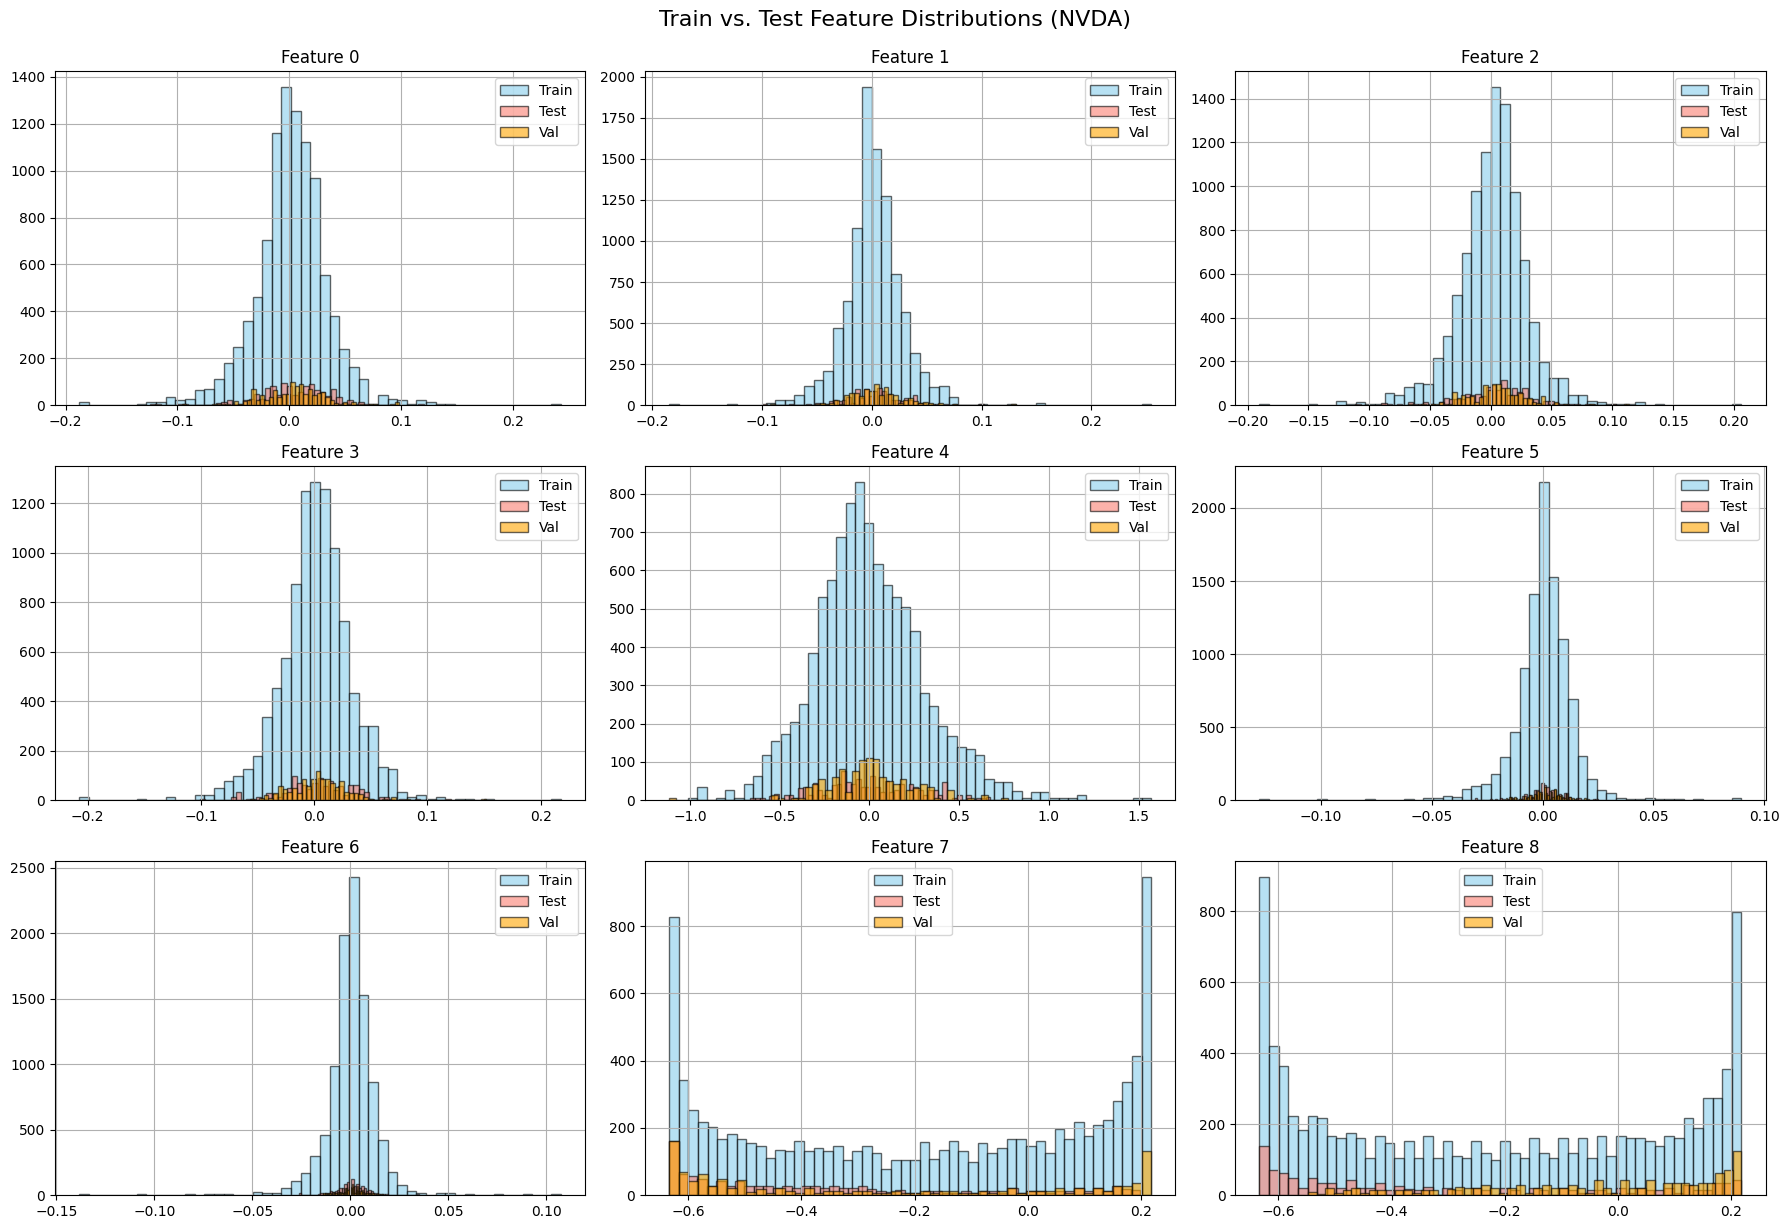

In [5]:
import torch
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(".."))

from utils.stock_data import get_data_loaders, get_log_return_loaders, StockIndex
stock = StockIndex.NVDA
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=32
)
input_dim = next(iter(train_dl))[0].shape[-1]

# --- Collect data ---
def get_flat_inputs(dataloader):
    all_x = []
    for xb, _, _  in dataloader:
        all_x.append(xb)
    all_x = torch.cat(all_x, dim=0)             # shape: (N, window, input_dim)
    return all_x.view(-1, all_x.shape[-1])       # shape: (N * window, input_dim)

flat_train = get_flat_inputs(train_dl)
flat_test  = get_flat_inputs(test_dl)
flat_val  = get_flat_inputs(val_dl)

# --- Plot side-by-side ---
cols = 3
rows = (input_dim + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

for i in range(input_dim):
    plt.subplot(rows, cols, i + 1)
    plt.hist(flat_train[:, i].numpy(), bins=50, alpha=0.6, label='Train', color='skyblue', edgecolor='black')
    plt.hist(flat_test[:, i].numpy(),  bins=50, alpha=0.6, label='Test', color='salmon', edgecolor='black')
    plt.hist(flat_val[:, i].numpy(), bins=50, alpha=0.6, label='Val', color='orange', edgecolor='black')

    plt.title(f"Feature {i}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle(f"Train vs. Test Feature Distributions ({stock.name})", fontsize=16, y=1.02)
plt.show()


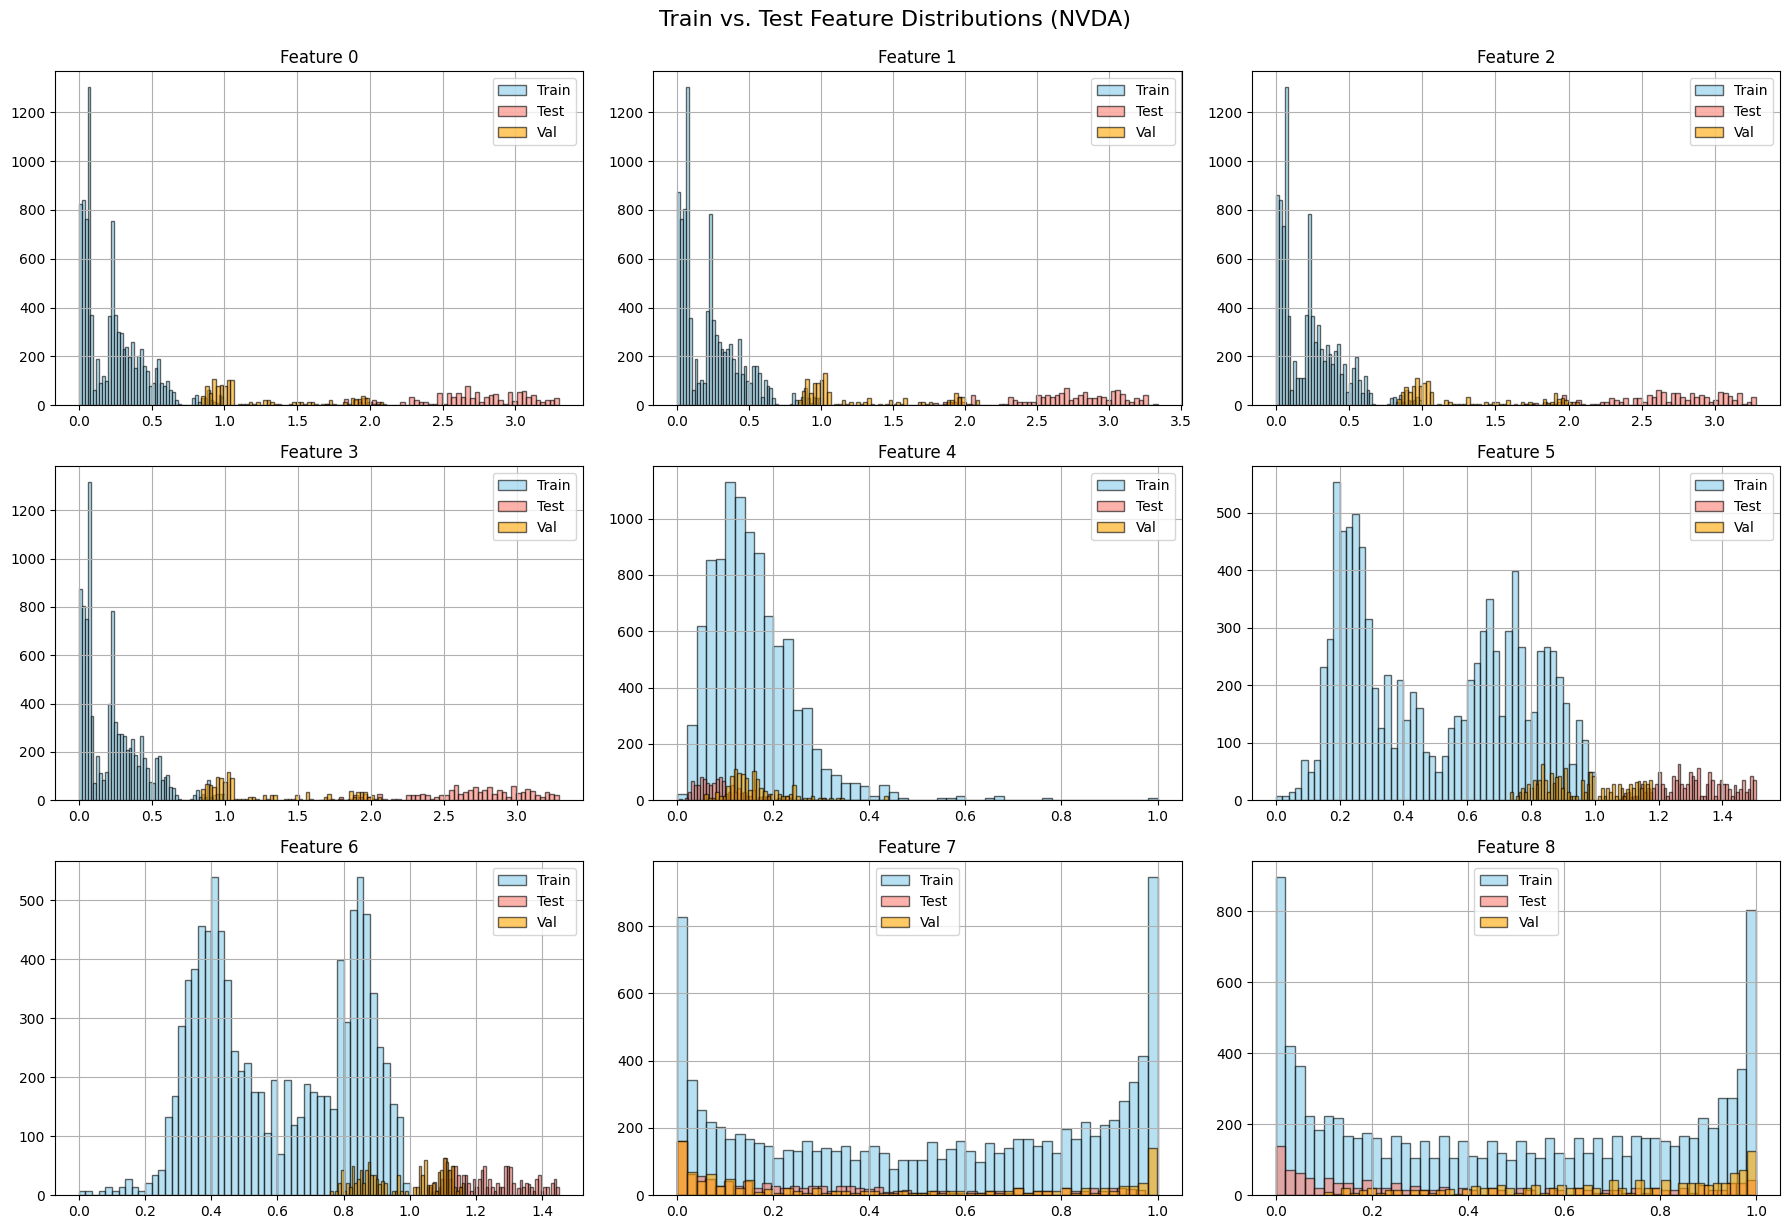

In [10]:
stock = StockIndex.NVDA
train_dl, val_dl, test_dl, scalars = get_data_loaders(
    stock,
    window_size=7,
    batch_size=32
)
input_dim = next(iter(train_dl))[0].shape[-1]

# --- Collect data ---
def get_flat_inputs(dataloader):
    all_x = []
    for xb, _ in dataloader:
        all_x.append(xb)
    all_x = torch.cat(all_x, dim=0)             # shape: (N, window, input_dim)
    return all_x.view(-1, all_x.shape[-1])       # shape: (N * window, input_dim)

flat_train = get_flat_inputs(train_dl)
flat_test  = get_flat_inputs(test_dl)
flat_val  = get_flat_inputs(val_dl)

# --- Plot side-by-side ---
cols = 3
rows = (input_dim + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

for i in range(input_dim):
    plt.subplot(rows, cols, i + 1)
    plt.hist(flat_train[:, i].numpy(), bins=50, alpha=0.6, label='Train', color='skyblue', edgecolor='black')
    plt.hist(flat_test[:, i].numpy(),  bins=50, alpha=0.6, label='Test', color='salmon', edgecolor='black')
    plt.hist(flat_val[:, i].numpy(), bins=50, alpha=0.6, label='Val', color='orange', edgecolor='black')

    plt.title(f"Feature {i}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle(f"Train vs. Test Feature Distributions ({stock.name})", fontsize=16, y=1.02)
plt.show()